<a href="https://colab.research.google.com/github/rajlm10/audio/blob/main/Unit_2_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets[audio] transformers -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.7 MB/s eta 0:00:00


In [31]:
from datasets import get_dataset_config_names,load_dataset,Audio
import IPython.display
import librosa
import matplotlib.pyplot as plt
import numpy as np



In [4]:
configs = get_dataset_config_names("PolyAI/minds14")
configs

['cs-CZ',
 'de-DE',
 'en-AU',
 'en-GB',
 'en-US',
 'es-ES',
 'fr-FR',
 'it-IT',
 'ko-KR',
 'nl-NL',
 'pl-PL',
 'pt-PT',
 'ru-RU',
 'zh-CN',
 'all']

In [6]:
data = load_dataset("PolyAI/minds14",name="en-GB",split="train")
data

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 592
})

In [7]:
data.features

{'path': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=8000, mono=True, decode=True, id=None),
 'transcription': Value(dtype='string', id=None),
 'english_transcription': Value(dtype='string', id=None),
 'intent_class': ClassLabel(names=['abroad', 'address', 'app_error', 'atm_limit', 'balance', 'business_loan', 'card_issues', 'cash_deposit', 'direct_debit', 'freeze', 'high_value_payment', 'joint_account', 'latest_transactions', 'pay_bill'], id=None),
 'lang_id': ClassLabel(names=['cs-CZ', 'de-DE', 'en-AU', 'en-GB', 'en-US', 'es-ES', 'fr-FR', 'it-IT', 'ko-KR', 'nl-NL', 'pl-PL', 'pt-PT', 'ru-RU', 'zh-CN'], id=None)}

In [8]:
data[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-GB~PAY_BILL/60268fc4dc3604f481bcb89c.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-GB~PAY_BILL/60268fc4dc3604f481bcb89c.wav',
  'array': array([0.        , 0.        , 0.        , ..., 0.01306152, 0.0189209 ,
         0.04772949]),
  'sampling_rate': 8000},
 'transcription': 'I want to pay a bill and I know I want to know how can I use my credit card to do so',
 'english_transcription': 'I want to pay a bill and I know I want to know how can I use my credit card to do so',
 'intent_class': 13,
 'lang_id': 3}

In [12]:
IPython.display.Audio(data[0]['audio']['path'])

In [17]:
data.features['intent_class'].names[13]

'pay_bill'

Text(0.5, 1.0, 'Time Domain Signal')

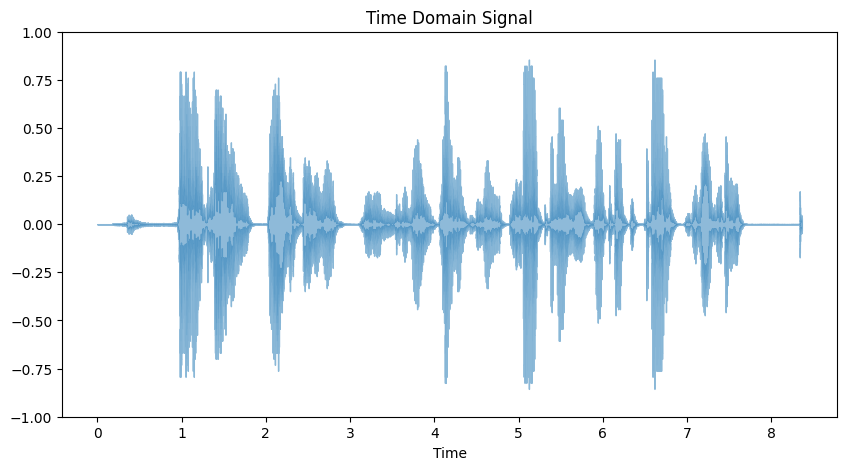

In [23]:
plt.figure(figsize=(10, 5))
librosa.display.waveshow(data[0]['audio']['array'], sr=data[0]['audio']['sampling_rate'],alpha=0.5)
plt.ylim((-1, 1))
plt.title("Time Domain Signal")

In [25]:
#Resampling

data = data.cast_column("audio",Audio(sampling_rate = 16_000))

In [27]:
new_column = [librosa.get_duration(path=x) for x in data["path"]]
data = data.add_column("duration", new_column)

#Using feature processor

In [28]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features\

data = data.map(prepare_dataset,num_proc=2)

Map (num_proc=2):   0%|          | 0/592 [00:00<?, ? examples/s]

In [32]:
np.array(data[0]['input_features']).shape

(1, 80, 836)

In [33]:
feature_extractor

WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

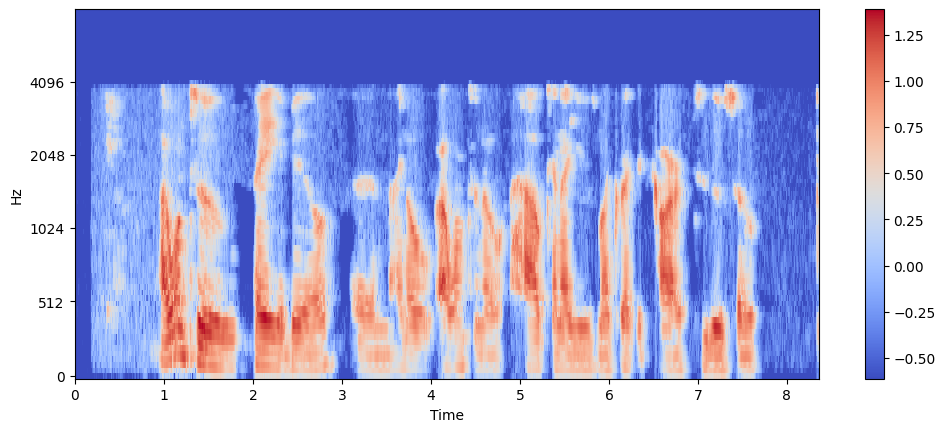

In [39]:
plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.array(data[0]['input_features'][0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()
